In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

from sklearn import linear_model
from statsmodels.stats.diagnostic import het_white

from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
import random

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Data and Descriptive Statistics

In [2]:
carbon_price_url = 'https://raw.githubusercontent.com/Erica-zya/Honor-Thesis/main/Data/Data_New/Daily%20Carbon%20Price.csv'
carbon_price = pd.read_csv(carbon_price_url, header=0)
carbon_price['Date'] = pd.to_datetime(carbon_price['Date'])

energy_price_url = 'https://raw.githubusercontent.com/Erica-zya/Honor-Thesis/main/Data/Data_New/Daily%20Energy.csv'
energy_price = pd.read_csv(energy_price_url, header=0)
energy_price['Date'] = pd.to_datetime(energy_price['Date'])

policy_url = 'https://raw.githubusercontent.com/Erica-zya/Honor-Thesis/main/Data/Data_New/Daily%20Policy.csv'
policy = pd.read_csv(policy_url, header=0)
policy['Date'] = pd.to_datetime(policy['Date'])

market_url = 'https://raw.githubusercontent.com/Erica-zya/Honor-Thesis/main/Data/Data_New/Daily%20Market.csv'
market = pd.read_csv(market_url, header=0)
market['Date'] = pd.to_datetime(market['Date'])

weather_url = 'https://raw.githubusercontent.com/Erica-zya/Honor-Thesis/main/Data/Data_New/Daily%20Weather.csv'
weather = pd.read_csv(weather_url, header=0)
weather['Date'] = pd.to_datetime(weather['Date'])

# Perform the merges
df = pd.merge(carbon_price, energy_price, on='Date', how='inner')
df = pd.merge(df, policy, on='Date', how='inner')
df = pd.merge(df, market, on='Date', how='inner')
df = pd.merge(df, weather, on='Date', how='inner')
df = df.dropna()

In [3]:
df = df.sort_values(by=['Date'])

In [4]:
df.head()

,Date,Carbon,Coal,Crude Oil,Natural Gas,Fit_for_55,Law,Compromise,EPU,DAX,SPGTCLNT,FTMIB,CAC40,AEX,STOXX,Temperature,Precipitation,Solar Energy,Wind Speed
1122,2021-01-04,33.89,69.30,51.09,19.845,0,0,0,231.37864,13726.74,2342.44,22315.87,5588.96,631.03,401.69,2.8,0.170,0.8,9.6
1121,2021-01-05,33.15,64.90,53.60,18.005,0,0,0,231.37864,13651.22,2390.04,22200.60,5564.60,633.62,400.94,2.7,0.012,0.6,9.4
1120,2021-01-06,33.83,64.25,54.30,17.565,0,0,0,231.37864,13891.97,2518.59,22734.32,5630.60,639.16,406.41,3.2,0.047,0.6,8.2
1119,2021-01-07,34.97,66.60,54.38,19.305,0,0,0,231.37864,13968.24,2692.75,22746.08,5669.85,637.41,408.49,2.8,0.125,1.6,7.1
1118,2021-01-08,35.14,68.50,55.99,20.120,0,0,0,231.37864,14049.53,2720.79,22793.94,5706.88,645.60,411.17,2.2,0.082,2.2,5.6


In [5]:
df['Carbon'].count()

763

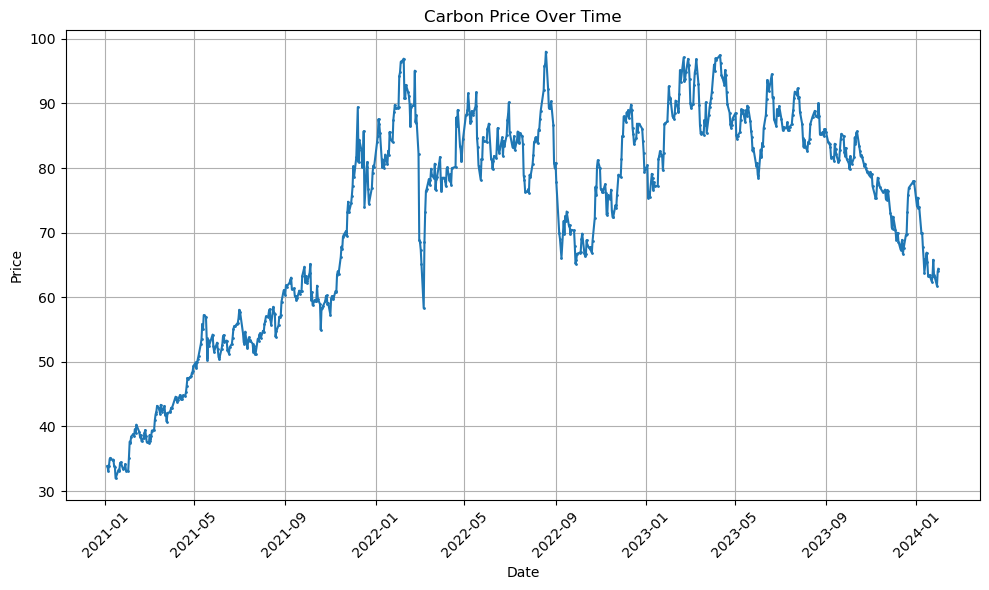

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Carbon'], marker='o', markersize=1, linestyle='-')
plt.title('Carbon Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
for column_name in df.columns[1:]:
    column = df[column_name]
    mean = column.mean()
    variance = column.var()
    sd = column.std()
    max_value = column.max()
    min_value = column.min()
    
    print(column_name)
    print("Mean:", mean)
    print("Variance:", variance)
    print("Standard Deviation:", sd)
    print("Maximum:", max_value)
    print("Minimum:", min_value)
    print()

Carbon
Mean: 72.98309305373526
Variance: 270.6564305779435
Standard Deviation: 16.45163914562751
Maximum: 98.01
Minimum: 31.96

Coal
Mean: 176.4729357798164
Variance: 8734.749716041804
Standard Deviation: 93.459882923326
Maximum: 439.0
Minimum: 63.75

Crude Oil
Mean: 83.81741808650057
Variance: 203.24808426985655
Standard Deviation: 14.256510241635452
Maximum: 127.98
Minimum: 51.09

Natural Gas
Mean: 72.44877326343381
Variance: 2982.6553067792283
Standard Deviation: 54.61369156886603
Maximum: 339.195
Minimum: 15.525

Fit_for_55
Mean: 0.8296199213630406
Variance: 0.14153620705668177
Standard Deviation: 0.376212980978437
Maximum: 1
Minimum: 0

Law
Mean: 0.21756225425950196
Variance: 0.1704523173135469
Standard Deviation: 0.4128587135008136
Maximum: 1
Minimum: 0

Compromise
Mean: 0.24508519003931847
Variance: 0.18526124601397334
Standard Deviation: 0.43041984853625576
Maximum: 1
Minimum: 0

EPU
Mean: 276.8771762858453
Variance: 4871.8912743413875
Standard Deviation: 69.79893462182204
Maxi

### Test for Multicollinearity

In [8]:
# Drop the 'Date' and 'Carbon' columns before calculating VIF
df_numeric = df.drop(columns=['Date', 'Carbon'])

# Initialize a DataFrame to store VIF results
vif_data = pd.DataFrame()
vif_data["Feature"] = df_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

print(vif_data)

          Feature           VIF
0            Coal     74.107461
1       Crude Oil    278.930559
2     Natural Gas     24.272691
3      Fit_for_55     38.194815
4             Law     15.447276
5      Compromise     12.519092
6             EPU     65.929011
7             DAX  12001.686917
8        SPGTCLNT    132.011553
9           FTMIB   5479.306812
10          CAC40   2743.642110
11            AEX   5818.402102
12          STOXX  12428.629219
13    Temperature     14.243452
14  Precipitation      1.304320
15   Solar Energy      7.960605
16     Wind Speed     10.874388


In [9]:
# Check correlations between stock indices
stock_columns = ['DAX', 'SPGTCLNT', 'FTMIB', 'CAC40', 'AEX', 'STOXX']
print(df_numeric[stock_columns].corr())

               DAX  SPGTCLNT     FTMIB     CAC40       AEX     STOXX
DAX       1.000000 -0.283918  0.912680  0.804923  0.854027  0.881508
SPGTCLNT -0.283918  1.000000 -0.548251 -0.620263 -0.263157 -0.262386
FTMIB     0.912680 -0.548251  1.000000  0.908032  0.811391  0.818125
CAC40     0.804923 -0.620263  0.908032  1.000000  0.818160  0.824418
AEX       0.854027 -0.263157  0.811391  0.818160  1.000000  0.951225
STOXX     0.881508 -0.262386  0.818125  0.824418  0.951225  1.000000


In [10]:
# Check correlations between energy prices
energy_columns = ['Coal', 'Crude Oil', 'Natural Gas']
print(df_numeric[energy_columns].corr())

                 Coal  Crude Oil  Natural Gas
Coal         1.000000   0.823675     0.865181
Crude Oil    0.823675   1.000000     0.606318
Natural Gas  0.865181   0.606318     1.000000


### PCA

In [11]:
# Step 1: Combine Stock Indices using PCA
cols_to_pca_stock = ['DAX', 'STOXX', 'FTMIB', 'CAC40', 'AEX','SPGTCLNT']

# Standardize the stock index data
scaler = StandardScaler()
X_pca_stock = scaler.fit_transform(df[cols_to_pca_stock])

# Apply PCA for stock indices
pca_stock = PCA(n_components=1)
X_pca_stock_reduced = pca_stock.fit_transform(X_pca_stock)

# Step 2 (Optional): Combine Energy Prices using PCA
cols_to_pca_energy = ['Crude Oil', 'Coal', 'Natural Gas']

# Standardize the energy price data
X_pca_energy = scaler.fit_transform(df[cols_to_pca_energy])

# Apply PCA for energy prices
pca_energy = PCA(n_components=1)
X_pca_energy_reduced = pca_energy.fit_transform(X_pca_energy)

# Step 3: Create df_arima without modifying df
# Select all other columns except the original stock indices and energy prices
other_columns = [col for col in df.columns if col not in cols_to_pca_stock + cols_to_pca_energy]

# Create the new DataFrame with the PCA components and other columns
df_arima = df[other_columns].copy()  # Copy the rest of the columns
df_arima['PCA_Stock_Index'] = X_pca_stock_reduced
df_arima['PCA_Energy_Prices'] = X_pca_energy_reduced

In [12]:
# Drop the 'Date' and 'Carbon' columns before calculating VIF
df_numeric_new = df_arima.drop(columns=['Date', 'Carbon','Law','Compromise','Fit_for_55'])

# Initialize a DataFrame to store VIF results
vif_data_new = pd.DataFrame()
vif_data_new["Feature"] = df_numeric_new.columns
vif_data_new["VIF"] = [variance_inflation_factor(df_numeric_new.values, i) for i in range(df_numeric_new.shape[1])]

print(vif_data_new)

             Feature        VIF
0                EPU  11.711455
1        Temperature   8.886121
2      Precipitation   1.258885
3       Solar Energy   4.239777
4         Wind Speed   9.320415
5    PCA_Stock_Index   1.227304
6  PCA_Energy_Prices   1.775570


# ARIMA Model

##### AR(1)

In [13]:
y = df_arima['Carbon']

modelAR1 = AutoReg(y, lags=1)
resultAR1 = modelAR1.fit()

print(resultAR1.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                     AutoReg(1)   Log Likelihood               -1631.975
Method:               Conditional MLE   S.D. of innovations              2.060
Date:                Wed, 04 Dec 2024   AIC                           3269.951
Time:                        10:21:35   BIC                           3283.859
Sample:                             1   HQIC                          3275.306
                                  763                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8752      0.339      2.578      0.010       0.210       1.541
Carbon.L1      0.9886      0.005    217.881      0.000       0.980       0.997
                                    Roots           

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
adf_result = adfuller(y)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.496120
p-value: 0.116421
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [15]:
y_diff = y.diff().dropna()


modelAR1_diff = AutoReg(y_diff, lags=1)
resultAR1_diff = modelAR1_diff.fit()

print(resultAR1_diff.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Carbon   No. Observations:                  762
Model:                     AutoReg(1)   Log Likelihood               -1632.661
Method:               Conditional MLE   S.D. of innovations              2.068
Date:                Wed, 04 Dec 2024   AIC                           3271.322
Time:                        10:21:35   BIC                           3285.226
Sample:                             1   HQIC                          3276.676
                                  762                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0428      0.075      0.571      0.568      -0.104       0.190
Carbon.L1     -0.0448      0.036     -1.236      0.216      -0.116       0.026
                                    Roots           

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


##### AR(2)

In [16]:
modelAR2 = AutoReg(y, lags=2)
resultAR2 = modelAR2.fit()

print(resultAR2.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                     AutoReg(2)   Log Likelihood               -1629.492
Method:               Conditional MLE   S.D. of innovations              2.059
Date:                Wed, 04 Dec 2024   AIC                           3266.983
Time:                        10:21:35   BIC                           3285.522
Sample:                             2   HQIC                          3274.122
                                  763                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8821      0.341      2.587      0.010       0.214       1.550
Carbon.L1      0.9469      0.036     26.151      0.000       0.876       1.018
Carbon.L2      0.0416      0.036      1.152      0.2

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
residuals = resultAR2.resid

if np.isnan(residuals).any() or np.isinf(residuals).any():
    residuals = residuals[~(np.isnan(residuals) | np.isinf(residuals))]

adf_test = adfuller(residuals)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -12.798021
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [18]:
X = df_arima.drop(columns=['Date','Carbon'])
_y = df_arima['Carbon']

<Figure size 1000x600 with 0 Axes>

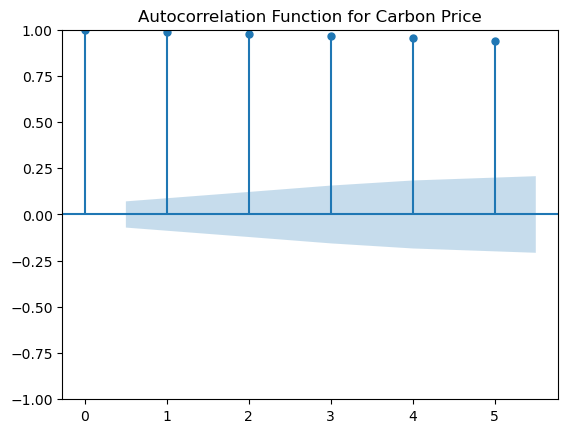

In [19]:
plt.figure(figsize=(10, 6))
plot_acf(df_arima['Carbon'], lags=5, alpha=0.05)
plt.title('Autocorrelation Function for Carbon Price')
plt.show()

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

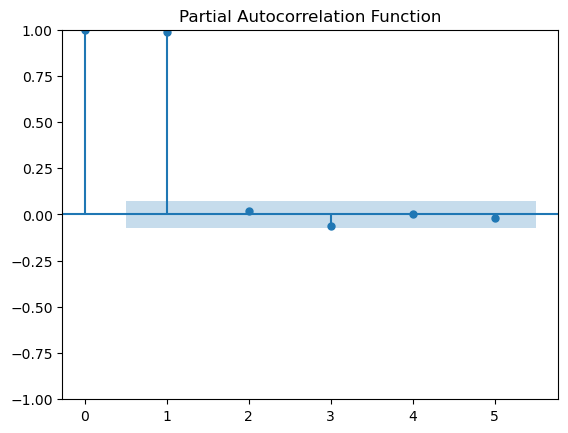

In [20]:
plt.figure(figsize=(10, 6))
plot_pacf(_y, lags=5, alpha=0.05)
plt.title('Partial Autocorrelation Function')
plt.show()

##### ARIMA(1,0,0)

In [21]:
model_arima100 = ARIMA(_y, exog=X, order=(1,0,0))
model_arima100_fit = model_arima100.fit()

print(model_arima100_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1605.502
Date:                Wed, 04 Dec 2024   AIC                           3237.003
Time:                        10:21:38   BIC                           3297.287
Sample:                             0   HQIC                          3260.213
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                51.5464    111.187      0.464      0.643    -166.376     269.469
Fit_for_55            1.7742      3.429      0.517      0.605      -4.947       8.496
Law                  -1.

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### ARIMA(1,0,1)

In [22]:
model_arima101 = ARIMA(_y, exog=X, order=(1,0,1))
model_arima101_fit = model_arima101.fit()

print(model_arima101_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1602.825
Date:                Wed, 04 Dec 2024   AIC                           3233.649
Time:                        10:21:39   BIC                           3298.571
Sample:                             0   HQIC                          3258.645
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                51.5986    105.569      0.489      0.625    -155.312     258.509
Fit_for_55            2.0090      2.963      0.678      0.498      -3.799       7.817
Law                  -1.

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### ARIMA(1,1,0)

In [23]:
model_arima110 = ARIMA(_y, exog=X, order=(1,1,0))
model_arima110_fit = model_arima110.fit()

print(model_arima110_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1597.397
Date:                Wed, 04 Dec 2024   AIC                           3218.794
Time:                        10:21:40   BIC                           3274.425
Sample:                             0   HQIC                          3240.214
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Fit_for_55            0.5834     48.254      0.012      0.990     -93.993      95.160
Law                  -2.9904     40.910     -0.073      0.942     -83.173      77.193
Compromise            2.

##### ARIMA(1,1,1); Best Performing Model

In [24]:
model_arima111 = ARIMA(_y, exog=X, order=(1,1,1))
model_arima111_fit = model_arima111.fit()

print(model_arima111_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1594.943
Date:                Wed, 04 Dec 2024   AIC                           3215.887
Time:                        10:21:42   BIC                           3276.154
Sample:                             0   HQIC                          3239.092
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Fit_for_55            0.6281     20.811      0.030      0.976     -40.160      41.417
Law                  -3.0275     10.457     -0.290      0.772     -23.523      17.468
Compromise            2.

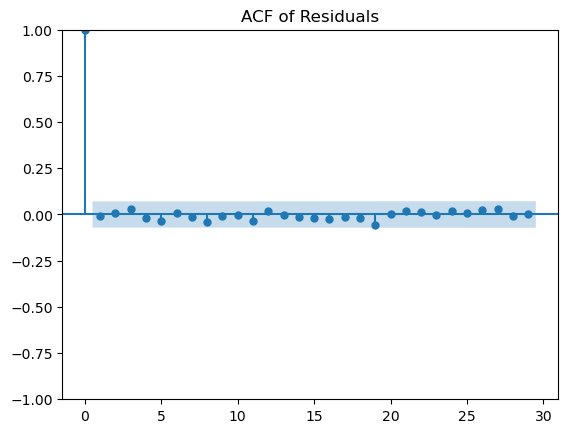

In [25]:
model_fit = model_arima111.fit()

# Get the residuals
residuals = model_fit.resid

# Plot the ACF of residuals
plot_acf(residuals, alpha=0.05)
plt.title('ACF of Residuals')
plt.show()

##### ARIMA(2,0,0)

In [26]:
model_arima200 = ARIMA(_y, exog=X, order=(2,0,0))
model_arima200_fit = model_arima200.fit()

print(model_arima200_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1602.221
Date:                Wed, 04 Dec 2024   AIC                           3232.443
Time:                        10:21:48   BIC                           3297.364
Sample:                             0   HQIC                          3257.438
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                51.1642    104.305      0.491      0.624    -153.269     255.598
Fit_for_55            1.7551      3.718      0.472      0.637      -5.531       9.042
Law                  -1.

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### ARIMA(2,1,0)

In [27]:
model_arima210 = ARIMA(_y, exog=X, order=(2,1,0))
model_arima210_fit = model_arima210.fit()

print(model_arima210_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1595.250
Date:                Wed, 04 Dec 2024   AIC                           3216.500
Time:                        10:21:50   BIC                           3276.767
Sample:                             0   HQIC                          3239.705
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Fit_for_55            0.7210     26.070      0.028      0.978     -50.375      51.817
Law                  -3.0913      8.263     -0.374      0.708     -19.287      13.105
Compromise            2.

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### ARIMA(2,0,1)

In [28]:
model_arima201 = ARIMA(_y, exog=X, order=(2,0,1))
model_arima201_fit = model_arima201.fit()

print(model_arima201_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1619.583
Date:                Wed, 04 Dec 2024   AIC                           3269.167
Time:                        10:21:52   BIC                           3338.726
Sample:                             0   HQIC                          3295.948
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                48.6777     37.638      1.293      0.196     -25.091     122.447
Fit_for_55           10.5794      0.597     17.735      0.000       9.410      11.749
Law                  -8.

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### ARIMA(2,1,1)

In [29]:
model_arima211 = ARIMA(_y, exog=X, order=(2,1,1))
model_arima211_fit = model_arima211.fit()

print(model_arima211_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  763
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1595.019
Date:                Wed, 04 Dec 2024   AIC                           3218.039
Time:                        10:21:55   BIC                           3282.942
Sample:                             0   HQIC                          3243.029
                                - 763                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Fit_for_55            1.1507     12.931      0.089      0.929     -24.194      26.495
Law                  -3.4142      5.421     -0.630      0.529     -14.039       7.211
Compromise            2.

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("Stationary")
    else:
        print("Non-stationary")

# Apply ADF test to each column
for column in df_arima.columns:
    adf_test(df_arima[column], title=column)

Augmented Dickey-Fuller Test: Date
ADF Test Statistic : 9.71877584213041
p-value : 1.0
# Lags Used : 10
# Observations Used : 752
Non-stationary
Augmented Dickey-Fuller Test: Carbon
ADF Test Statistic : -2.496119824433623
p-value : 0.11642127012289788
# Lags Used : 5
# Observations Used : 757
Non-stationary
Augmented Dickey-Fuller Test: Fit_for_55
ADF Test Statistic : -2.2105125985713
p-value : 0.202452138872532
# Lags Used : 0
# Observations Used : 762
Non-stationary
Augmented Dickey-Fuller Test: Law
ADF Test Statistic : -0.5254702737680361
p-value : 0.88694957949878
# Lags Used : 0
# Observations Used : 762
Non-stationary
Augmented Dickey-Fuller Test: Compromise
ADF Test Statistic : -0.5680046096316663
p-value : 0.8780490322937853
# Lags Used : 0
# Observations Used : 762
Non-stationary
Augmented Dickey-Fuller Test: EPU
ADF Test Statistic : -2.1566321856318083
p-value : 0.22236009113880895
# Lags Used : 0
# Observations Used : 762
Non-stationary
Augmented Dickey-Fuller Test: Temperat

In [31]:
df_diff = df_arima.diff().dropna()  # Apply differencing to make data stationary

In [32]:
from statsmodels.tsa.api import VAR

# Combine Carbon prices with exogenous variables
combined_data = df_diff[['Carbon', 'Fit_for_55', 'Law', 'Compromise', 'EPU', 
                         'Temperature', 'Precipitation', 'Solar Energy', 
                         'Wind Speed', 'PCA_Stock_Index', 'PCA_Energy_Prices']]

# Fit the VAR model
model = VAR(combined_data)
var_model_fit = model.fit(maxlags=15, ic='aic')  # Select lag length based on AIC
print(var_model_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Dec, 2024
Time:                     10:21:56
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -8.65377
Nobs:                     760.000    HQIC:                  -9.60222
Log likelihood:          -7734.78    FPE:                3.73203e-05
AIC:                     -10.1962    Det(Omega_mle):     2.68853e-05
--------------------------------------------------------------------
Results for equation Carbon
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.044875         0.075113            0.597           0.550
L1.Carbon                   -0.063358         0.038133           -1.661           0.097
L1.Fit_for_55               -0.

# Performance and Results

## ARIMA Model

In [33]:
y = df_arima['Carbon']

In [34]:
train_size = int(len(df_arima) * 0.8)
train_indices = df_arima.index[:train_size]
test_indices = df_arima.index[train_size:]

y_train, y_test = y.loc[train_indices], y.loc[test_indices]

### In Sample

In [35]:
a = ARIMA(y_train, order=(1,1,1))
a_fit = a.fit()

print(a_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  610
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1339.922
Date:                Wed, 04 Dec 2024   AIC                           2685.843
Time:                        10:21:56   BIC                           2699.079
Sample:                             0   HQIC                          2690.992
                                - 610                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8177      0.140     -5.846      0.000      -1.092      -0.544
ma.L1          0.7631      0.152      5.005      0.000       0.464       1.062
sigma2         4.7706      0.147     32.435      0.0

In [36]:
y_train_pred_a = a_fit.predict(in_sample=True, return_conf_int=False)

In [37]:
y_train_pred_a.iloc[0] = df['Carbon'].iloc[0]

In [38]:
y_train_reshaped_a = y_train.values.reshape(-1, 1)
y_train_pred_reshaped_a = y_train_pred_a.values.reshape(-1, 1)

reg = linear_model.LinearRegression()

reg.fit(y_train_pred_reshaped_a, y_train_reshaped_a)

r_squared_a = reg.score(y_train_pred_reshaped_a, y_train_reshaped_a)
r_squared_a

0.9847067852840609

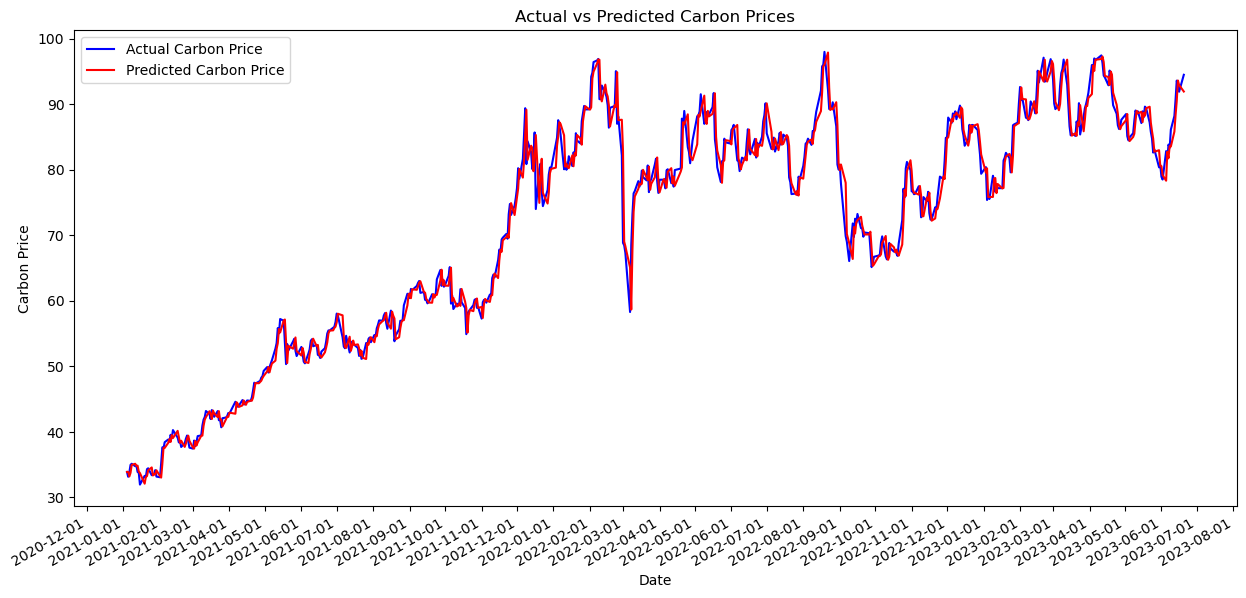

In [39]:
dates = df_arima['Date']
date_train = dates[train_indices]

plt.figure(figsize=(15, 7))
plt.plot(date_train, y_train, label='Actual Carbon Price', color='blue')
plt.plot(date_train, y_train_pred_a, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

### Out of Sample

In [40]:
y_test_pred_a = []  # Store predictions
history = y_train.tolist()  # Initialize with training data

# Loop through test set to predict each day and update with actual data
for t in range(len(y_test)):
    a_test_model = ARIMA(history, order=(1,1,1))
    a_test_model_fit = a_test_model.fit()
    
    # Predict the next value
    forecast = a_test_model_fit.forecast()
    y_test_pred_a.append(forecast[0])
    
    # Update history with actual data for next iteration
    history.append(y_test.iloc[t])

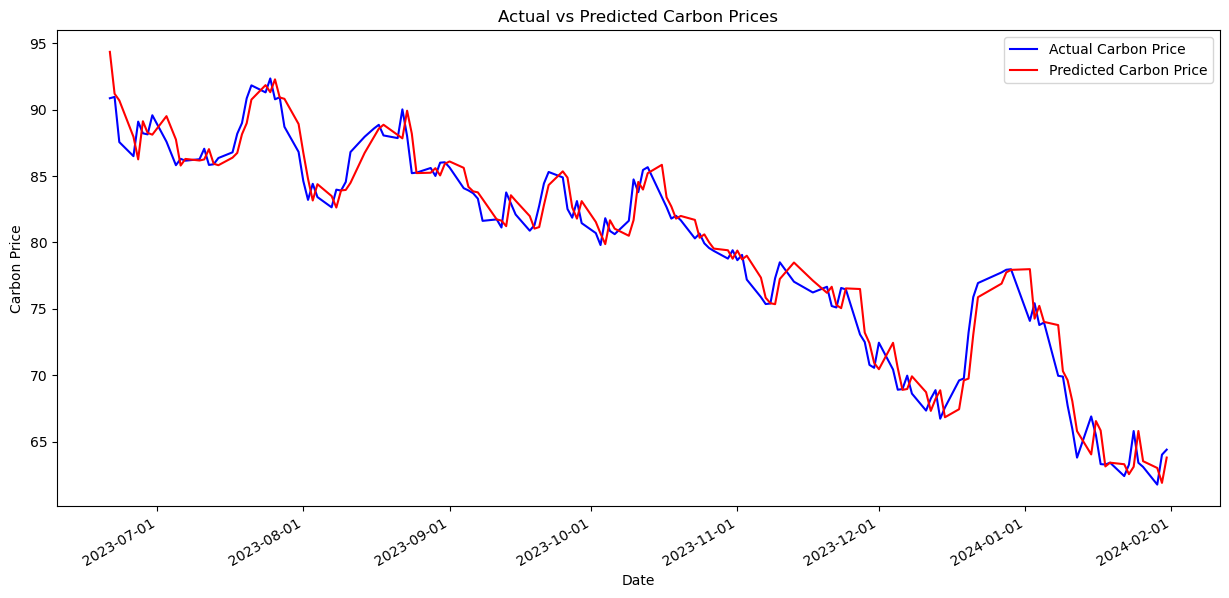

In [41]:
dates = df_arima['Date']
date_test = dates[test_indices]

plt.figure(figsize=(15, 7))
plt.plot(date_test, y_test, label='Actual Carbon Price', color='blue')
plt.plot(date_test, y_test_pred_a, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format for date rotation and readability
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

In [42]:
y_test_pred_a = np.array(y_test_pred_a)

# Reshape the test set values and predictions into the required format
y_test_reshaped_a = y_test.values.reshape(-1, 1)
y_test_pred_reshaped_a = y_test_pred_a.reshape(-1, 1)

# Initialize and fit the linear regression model
reg = linear_model.LinearRegression()
reg.fit(y_test_pred_reshaped_a, y_test_reshaped_a)

# Calculate R-squared on the test data
r_squared_a_test = reg.score(y_test_pred_reshaped_a, y_test_reshaped_a)
r_squared_a_test


0.9669009386886934

In [43]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_a))
print(f"Out-of-Sample RMSE: {rmse}")

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_a)
print(f"Out-of-Sample MSE: {mse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_a)
print(f"Out-of-Sample MAE: {mae}")

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_test_pred_a) / y_test)) * 100
print(f"Out-of-Sample MAPE: {mape}%") 

Out-of-Sample RMSE: 1.4724394392910662
Out-of-Sample MSE: 2.1680779023797894
Out-of-Sample MAE: 1.1658466503933282
Out-of-Sample MAPE: 1.4968705734676724%


## ARIMAX Model

In [44]:
X = df_arima.drop(['Date', 'Carbon'], axis=1)
y = df_arima['Carbon']

In [45]:
train_size = int(len(df_arima) * 0.8)
train_indices = df_arima.index[:train_size]
test_indices = df_arima.index[train_size:]

y_train, y_test = y.loc[train_indices], y.loc[test_indices]
X_train, X_test = X.loc[train_indices], X.loc[test_indices]

### In Sample

In [46]:
arima_model = ARIMA(y_train, exog=X_train, order=(1,1,1))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Carbon   No. Observations:                  610
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1307.670
Date:                Wed, 04 Dec 2024   AIC                           2641.339
Time:                        10:22:18   BIC                           2698.693
Sample:                             0   HQIC                          2663.651
                                - 610                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Fit_for_55            0.7689     25.892      0.030      0.976     -49.979      51.517
Law                  -3.0564     10.113     -0.302      0.762     -22.877      16.765
Compromise            2.

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
y_train_pred_arima = arima_model_fit.predict(in_sample=True, exog=X_train, return_conf_int=False)

In [48]:
y_train_pred_arima.iloc[0] = df['Carbon'].iloc[0]

In [49]:
y_train_reshaped_arima = y_train.values.reshape(-1, 1)
y_train_pred_reshaped_arima = y_train_pred_arima.values.reshape(-1, 1)

reg = linear_model.LinearRegression()

reg.fit(y_train_pred_reshaped_arima, y_train_reshaped_arima)

r_squared_arima_train = reg.score(y_train_pred_reshaped_arima, y_train_reshaped_arima)
r_squared_arima_train

0.9862042718224211

In [50]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_arima))
print(f"Out-of-Sample RMSE: {rmse}")

# Calculate MSE
mse = mean_squared_error(y_train, y_train_pred_arima)
print(f"Out-of-Sample MSE: {mse}")

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred_arima)
print(f"Out-of-Sample MAE: {mae}")

# Calculate MAPE
mape = np.mean(np.abs((y_train - y_train_pred_arima) / y_train)) * 100
print(f"Out-of-Sample MAPE: {mape}%") 

Out-of-Sample RMSE: 2.06981428393653
Out-of-Sample MSE: 4.284131169987689
Out-of-Sample MAE: 1.495016712305269
Out-of-Sample MAPE: 2.0825571013983515%


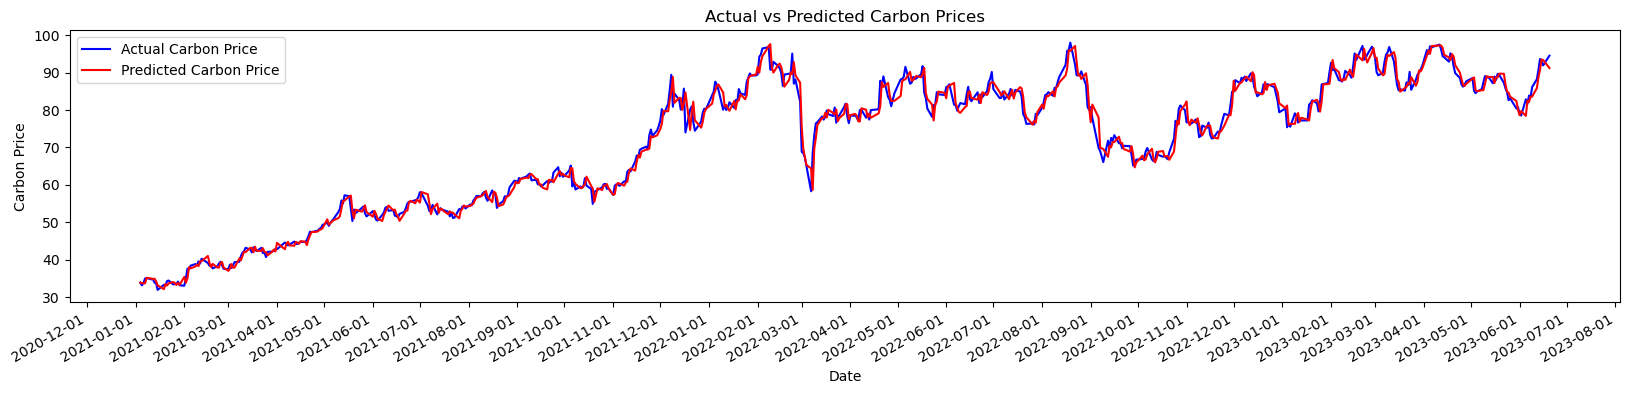

In [51]:
dates = df_arima['Date']
date_train = dates[train_indices]

plt.figure(figsize=(20,4))
plt.plot(date_train, y_train, label='Actual Carbon Price', color='blue')
plt.plot(date_train, y_train_pred_arima, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

### Out of Sample

In [52]:
# Perform out-of-sample test with daily actual data updates
y_test_pred_arima = []  # Store predictions
history = y_train.tolist()  # Initialize with training data
exog_history = X_train.values.tolist()

# Loop through test set to predict each day and update with actual data
for t in range(len(y_test)):
    X_input = X_test.iloc[t].values.reshape(1, -1)
    arima_test_model = ARIMA(history, exog=exog_history, order=(1,1,1))
    arima_test_model_fit = arima_test_model.fit()
    
    # Predict the next value
    forecast = arima_test_model_fit.forecast(exog=X_input)
    y_test_pred_arima.append(forecast[0])
    
    # Update history with actual data for next iteration
    history.append(y_test.iloc[t])
    exog_history.append(X_input[0])

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eri

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eri

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eri

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eri

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eri

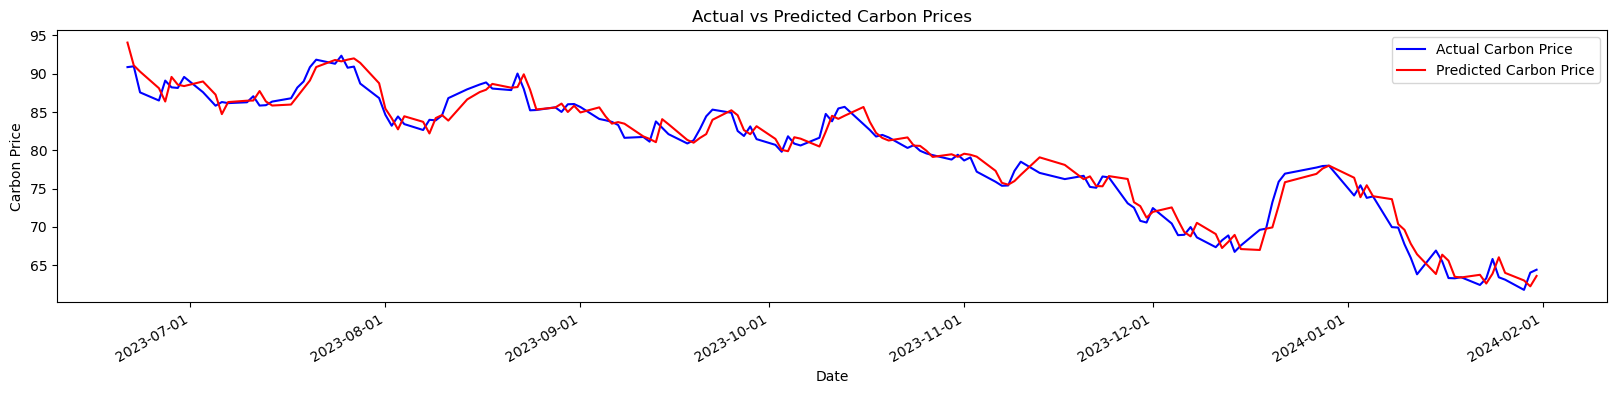

In [53]:
dates = df_arima['Date']
date_test = dates[test_indices]

plt.figure(figsize=(20,4))
plt.plot(date_test, y_test, label='Actual Carbon Price', color='blue')
plt.plot(date_test, y_test_pred_arima, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

In [54]:
residuals = y_test - y_test_pred_arima

# Perform White test
exog = np.column_stack([X_test, X_test**2])
white_test = het_white(residuals, exog)

# Extract test results
white_stat, white_p_val, _, _ = white_test

print(f"White test statistic: {white_stat}")
print(f"p-value of the White test: {white_p_val}")

White test statistic: 123.13292024179155
p-value of the White test: 0.16767144922798916


In [55]:
y_test_pred_arima = np.array(y_test_pred_arima)
y_test_reshaped_arima = y_test.values.reshape(-1, 1)
y_test_pred_reshaped_arima = y_test_pred_arima.reshape(-1, 1)

reg = linear_model.LinearRegression()

reg.fit(y_test_pred_reshaped_arima, y_test_reshaped_arima)

r_squared_arima_test = reg.score(y_test_pred_reshaped_arima, y_test_reshaped_arima)
r_squared_arima_test

0.9674471200945215

In [56]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_arima))
print(f"Out-of-Sample RMSE: {rmse}")

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_arima)
print(f"Out-of-Sample MSE: {mse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_arima)
print(f"Out-of-Sample MAE: {mae}")

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_test_pred_arima) / y_test)) * 100
print(f"Out-of-Sample MAPE: {mape}%") 

Out-of-Sample RMSE: 1.4578940644010854
Out-of-Sample MSE: 2.1254551030159163
Out-of-Sample MAE: 1.1876297160384974
Out-of-Sample MAPE: 1.525404497470119%


## Random Forest

In [57]:
X = df.drop(['Date', 'Carbon'], axis=1)
y = df['Carbon']

In [58]:
train_size = int(len(df_arima) * 0.8)
train_indices = df.index[:train_size]
test_indices = df.index[train_size:]

y_train, y_test = y.loc[train_indices], y.loc[test_indices]
X_train, X_test = X.loc[train_indices], X.loc[test_indices]

In [59]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
rf = RandomForestRegressor(random_state=seed_value)

param_grid = {
    'n_estimators': [25, 50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

In [60]:
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150, random_state=42)

### Without Difference - In Sample

In [61]:
y_train_pred_rf = best_rf_model.predict(X_train)

# Reshape the data for sklearn
y_train_pred_rf_reshaped = y_train_pred_rf.reshape(-1, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)

# Initialize the Linear Regression model
reg = linear_model.LinearRegression()

# Fit the linear regression model on the predicted and actual values
reg.fit(y_train_pred_rf_reshaped, y_train_reshaped)

# Calculate the R-squared value
r_squared = r2_score(y_train_reshaped, y_train_pred_rf_reshaped)
print("R-squared value:", r_squared)

R-squared value: 0.9907864766052338


In [62]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
print(f"Out-of-Sample RMSE: {rmse}")

# Calculate MSE
mse = mean_squared_error(y_train, y_train_pred_rf)
print(f"Out-of-Sample MSE: {mse}")

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred_rf)
print(f"Out-of-Sample MAE: {mae}")

# Calculate MAPE
mape = np.mean(np.abs((y_train - y_train_pred_rf) / y_train)) * 100
print(f"Out-of-Sample MAPE: {mape}%")

Out-of-Sample RMSE: 1.6867798796862714
Out-of-Sample MSE: 2.8452263625144325
Out-of-Sample MAE: 1.1701709198483345
Out-of-Sample MAPE: 1.5816588136102854%


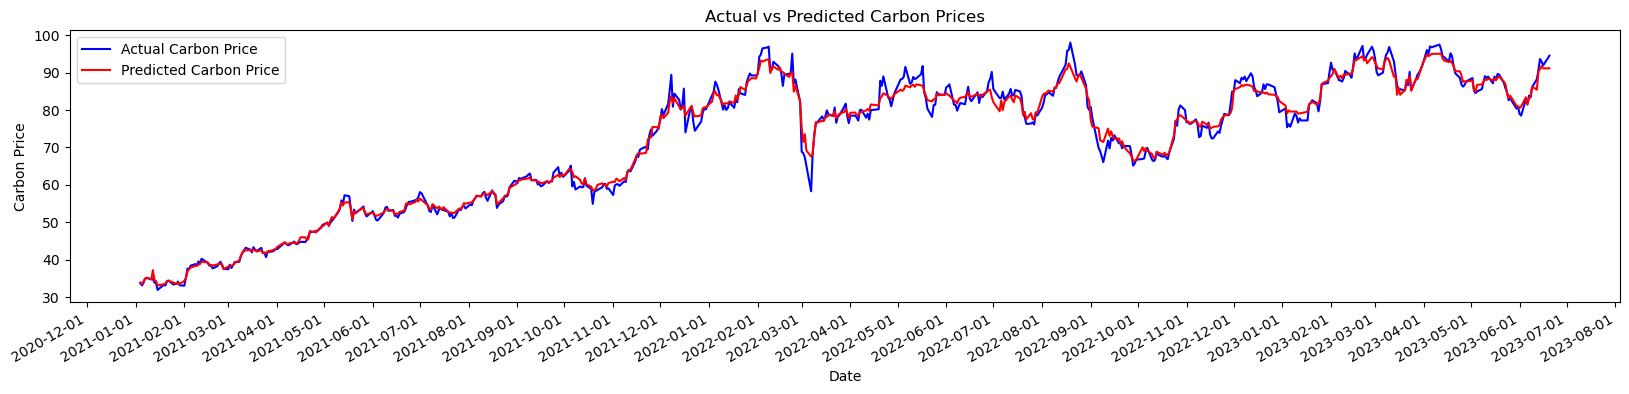

In [63]:
dates = df['Date']
date_train = dates[train_indices]

plt.figure(figsize=(20,4))
plt.plot(date_train, y_train, label='Actual Carbon Price', color='blue')
plt.plot(date_train, y_train_pred_rf, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

### Without Difference - Out of Sample

In [64]:
tscv = TimeSeriesSplit(n_splits=5)

In [65]:
# Initialize the RandomForestRegressor with your chosen hyperparameters
rf_model = best_rf_model

# Perform cross-validation
cv_results = cross_val_score(rf_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

# Convert negative MSE to positive RMSE
rmse_cv = np.sqrt(-cv_results)

print("Time-Series Cross-Validation RMSE for each fold:", rmse_cv)
print("Average RMSE across folds:", np.mean(rmse_cv))

Time-Series Cross-Validation RMSE for each fold: [ 8.13658947 22.81910416 11.89599407  9.27027592 18.50909597]
Average RMSE across folds: 14.126211918002705


In [66]:
history_X_rf = X_train.values.tolist()
history_y_rf = y_train.tolist()
y_test_pred_rf = []

# Loop through the test set, predicting day by day, and updating the history
for t in range(len(y_test)):
    # Get the exogenous input for day t
    X_input = X_test.iloc[t].values.reshape(1, -1)
    
    # Train a new Random Forest model on the current history
    rf_test_model = RandomForestRegressor(
        max_depth=best_rf_model.max_depth,
        max_features=best_rf_model.max_features,
        min_samples_leaf=best_rf_model.min_samples_leaf,
        min_samples_split=best_rf_model.min_samples_split,
        n_estimators=best_rf_model.n_estimators,
        random_state=42
    )
    rf_test_model.fit(np.array(history_X_rf), np.array(history_y_rf))
    
    # Predict the next value (carbon price for day t)
    forecast = rf_test_model.predict(X_input)
    y_test_pred_rf.append(forecast[0])  # Store the prediction
    
    # Update history with the actual test data for the next iteration
    history_y_rf.append(y_test.iloc[t])  # Append the actual value for day t
    history_X_rf.append(X_input[0])  # Append the exogenous variables for day 

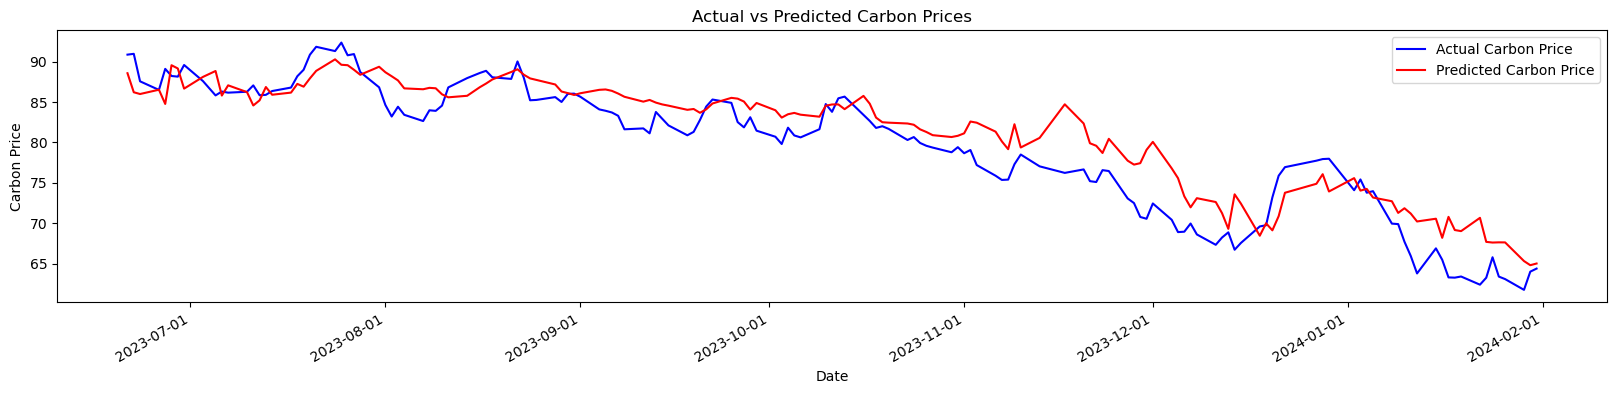

In [67]:
dates = df['Date']
date_test = dates[test_indices]

plt.figure(figsize=(20,4))
plt.plot(date_test, y_test, label='Actual Carbon Price', color='blue')
plt.plot(date_test, y_test_pred_rf, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

In [68]:
y_test_pred_rf = np.array(y_test_pred_rf)
# Reshape the data for sklearn
y_test_pred_rf_reshaped = y_test_pred_rf.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Initialize the Linear Regression model
reg = linear_model.LinearRegression()

# Fit the linear regression model on the predicted and actual values
reg.fit(y_test_pred_rf_reshaped, y_test_reshaped)

# Calculate the R-squared value
r_squared = r2_score(y_test_reshaped, y_test_pred_rf_reshaped)
print("R-squared value:", r_squared)

R-squared value: 0.8258174444888462


In [69]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(f"Out-of-Sample RMSE: {rmse}")

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred_rf)
print(f"Out-of-Sample MSE: {mse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred_rf)
print(f"Out-of-Sample MAE: {mae}")

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_test_pred_rf) / y_test)) * 100
print(f"Out-of-Sample MAPE: {mape}%")

Out-of-Sample RMSE: 3.333326247427527
Out-of-Sample MSE: 11.111063871789279
Out-of-Sample MAE: 2.7175130959595504
Out-of-Sample MAPE: 3.597134752101985%


### With Difference - In Sample

In [70]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)



# First, difference the target variable
y_diff = y.diff().dropna()  # First difference of the carbon price to make it stationary

train_size_diff = int(len(y_diff) * 0.8)
train_indices_diff = y_diff.index[:train_size_diff]
test_indices_diff = y_diff.index[train_size_diff:]

y_train_diff, y_test_diff = y_diff.loc[train_indices_diff], y_diff.loc[test_indices_diff]
X_train_diff, X_test_diff = X.loc[train_indices_diff], X.loc[test_indices_diff]

In [71]:
param_grid = {
    'n_estimators': [25, 50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_diff, y_train_diff)
best_rf_model = grid_search.best_estimator_

In [72]:
best_rf_model.fit(X_train_diff, y_train_diff)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=200, random_state=42)

In [73]:
y_train_pred_diff = best_rf_model.predict(X_train_diff)

y_train_pred_diff = np.insert(y_train_pred_diff, 0, 0)

y_train_pred = [x + y for x, y in zip(y_train[:-1], y_train_pred_diff)]

y_train_pred = np.array(y_train_pred)

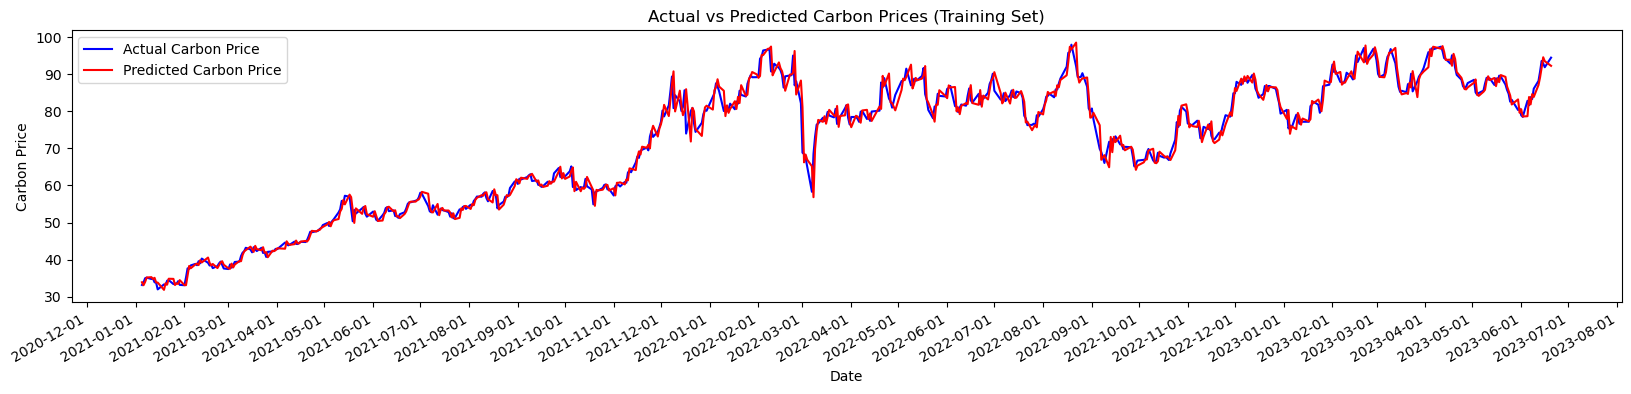

In [74]:
date_train = df['Date'][train_indices_diff]

plt.figure(figsize=(20,4))
plt.plot(date_train, y_train[train_indices_diff], label='Actual Carbon Price', color='blue')
plt.plot(date_train, y_train_pred, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices (Training Set)')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

In [75]:
r_squared_train = r2_score(y_train.loc[train_indices_diff], y_train_pred)
print("In-Sample R-squared:", r_squared_train)

rmse_train = np.sqrt(mean_squared_error(y_train.loc[train_indices_diff], y_train_pred))
print(f"In-Sample RMSE: {rmse_train}")

mse_train = mean_squared_error(y_train.loc[train_indices_diff], y_train_pred)
print(f"In-Sample MSE: {mse_train}")

mae_train = mean_absolute_error(y_train.loc[train_indices_diff], y_train_pred)
print(f"In-Sample MAE: {mae_train}")

mape_train = np.mean(np.abs((y_train.loc[train_indices_diff] - y_train_pred) / y_train.loc[train_indices_diff])) * 100
print(f"In-Sample MAPE: {mape_train}%")

In-Sample R-squared: 0.9839366615412601
In-Sample RMSE: 2.2207176037409613
In-Sample MSE: 4.931586675564996
In-Sample MAE: 1.5640583371565882
In-Sample MAPE: 2.1731396254115984%


### With Difference - Out of Sample

In [76]:
history_X_rf = X_train_diff.values.tolist()  # Exogenous variables (training set)
history_y_rf = y_train_diff.tolist()  # Differenced target values (training set)

# Start with the last value from the original (non-differenced) training data
last_train_value = y.loc[train_indices_diff[-1]]  # Last value of the training set

y_test_pred_rf = []  # Store differenced predictions

y_test_pred = []

# Loop through the test set, predicting day by day
for t in range(len(y_test_diff)):
    X_input = X_test_diff.iloc[t].values.reshape(1, -1)

    # Train a new Random Forest model on the current history
    rf_test_model = RandomForestRegressor(
        max_depth=best_rf_model.max_depth,
        max_features=best_rf_model.max_features,
        min_samples_leaf=best_rf_model.min_samples_leaf,
        min_samples_split=best_rf_model.min_samples_split,
        n_estimators=best_rf_model.n_estimators,
        random_state=42
    )
    rf_test_model.fit(np.array(history_X_rf), np.array(history_y_rf))

    # Predict the next difference
    forecast_diff = rf_test_model.predict(X_input)
    y_test_pred_rf.append(forecast_diff[0])  # Store the differenced prediction
    
    # Convert the differenced prediction back to the original scale
    if t == 0:
        y_test_pred.append(y_train.iloc[-1]+forecast_diff[0])
    else:
        # Subsequent predictions: add the difference to the last predicted value
        y_test_pred.append(y_test.iloc[t-1]+forecast_diff[0])

    # Update history for the next iteration
    history_y_rf.append(y_test_diff.iloc[t])  # Add actual differenced value
    history_X_rf.append(X_input[0])  # Add exogenous variables

# Convert y_test_pred to a NumPy array for further analysis
y_test_pred = np.array(y_test_pred)

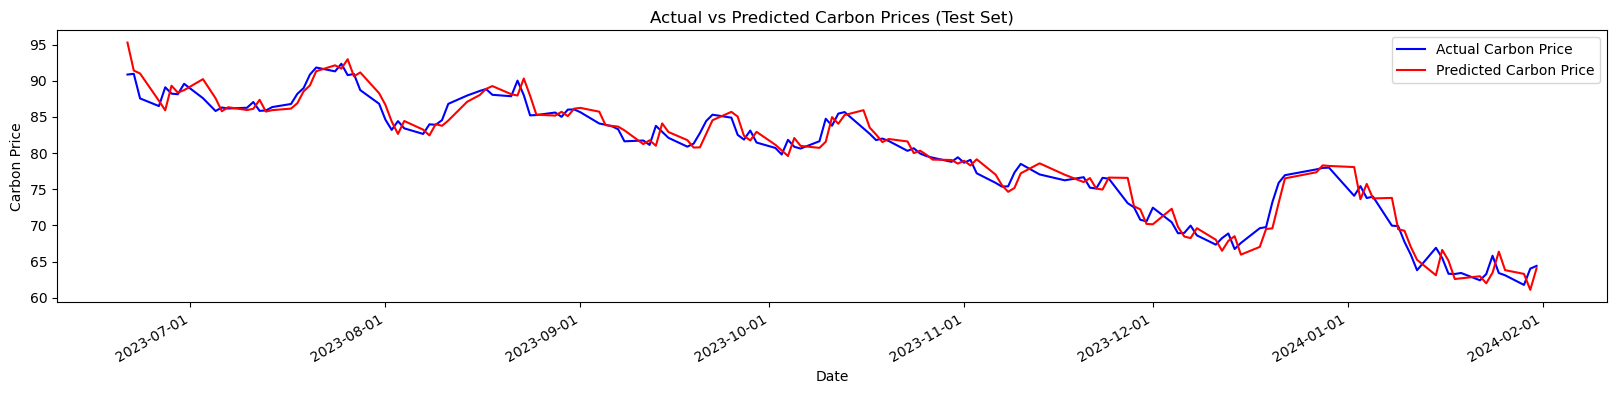

In [77]:
date_test = df['Date'][test_indices_diff]

plt.figure(figsize=(20,4))
plt.plot(date_test, y_test, label='Actual Carbon Price', color='blue')
plt.plot(date_test, y_test_pred, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

In [78]:
r_squared_test = r2_score(y_test, y_test_pred)
print("Out-of-Sample R-squared:", r_squared_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Out-of-Sample RMSE: {rmse_test}")

mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Out-of-Sample MSE: {mse_test}")

mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Out-of-Sample MAE: {mae_test}")

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f"Out-of-Sample MAPE: {mape_test}%")

Out-of-Sample R-squared: 0.9628006237949805
Out-of-Sample RMSE: 1.5404348017397793
Out-of-Sample MSE: 2.3729393784110733
Out-of-Sample MAE: 1.209694941370652
Out-of-Sample MAPE: 1.5547120229456803%


## With Median

In [79]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Define custom Random Forest Regressor with median prediction
class MedianRandomForestRegressor(RandomForestRegressor):
    def predict(self, X):
        # Get predictions from each individual tree
        all_tree_predictions = np.array([tree.predict(X) for tree in self.estimators_])
        # Return the median across the trees for each sample
        return np.median(all_tree_predictions, axis=0)

# First, difference the target variable to make it stationary
y_diff = y.diff().dropna()

# Split the differenced dataset into training and testing sets
train_size_diff = int(len(y_diff) * 0.8)
train_indices_diff = y_diff.index[:train_size_diff]
test_indices_diff = y_diff.index[train_size_diff:]

y_train_diff, y_test_diff = y_diff.loc[train_indices_diff], y_diff.loc[test_indices_diff]
X_train_diff, X_test_diff = X.loc[train_indices_diff], X.loc[test_indices_diff]

### In Sample

In [80]:
param_grid = {
    'n_estimators': [25, 50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
rf = MedianRandomForestRegressor(random_state=seed_value)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_diff, y_train_diff)
best_rf_model = grid_search.best_estimator_

In [81]:
best_rf_model.fit(X_train_diff, y_train_diff)

y_train_pred_diff = best_rf_model.predict(X_train_diff)

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\

C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\anaconda3\envs\honorthesis\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Erica Zhao\

In [82]:
# Invert the differencing to recover the original scale
y_train_pred_diff = np.insert(y_train_pred_diff, 0, 0)
y_train_pred = [x + y for x, y in zip(y_train[:-1], y_train_pred_diff)]

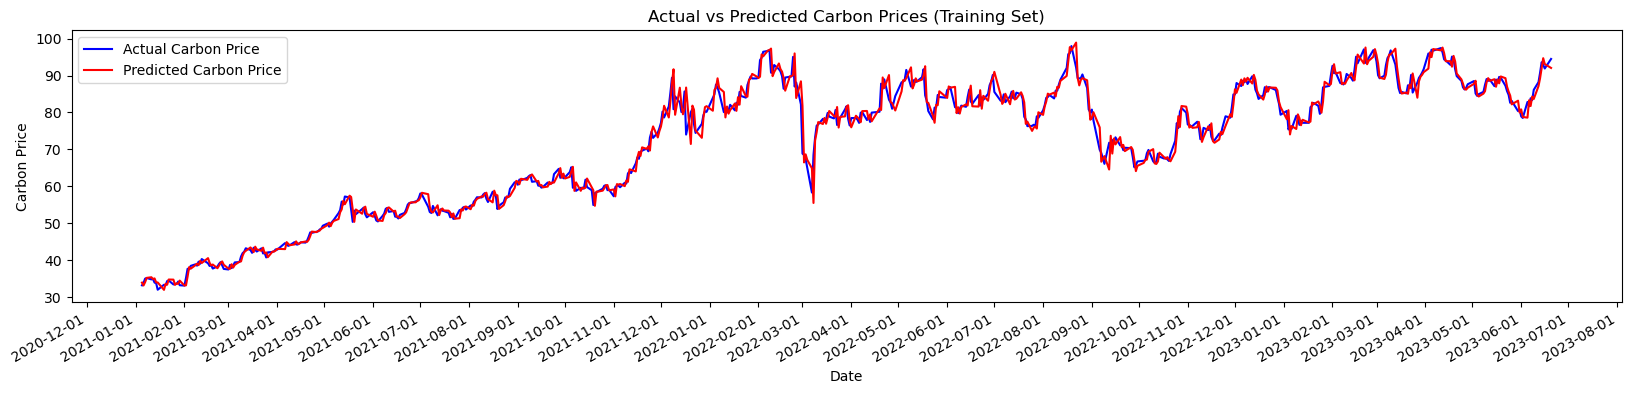

In [83]:
y_train_pred = np.array(y_train_pred)
date_train = df['Date'][train_indices_diff]

plt.figure(figsize=(20,4))
plt.plot(date_train, y_train[train_indices_diff], label='Actual Carbon Price', color='blue')
plt.plot(date_train, y_train_pred, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices (Training Set)')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

In [84]:
# Evaluate model performance on training set
r_squared_train = r2_score(y_train.loc[train_indices_diff], y_train_pred)
print("In-Sample R-squared:", r_squared_train)

rmse_train = np.sqrt(mean_squared_error(y_train.loc[train_indices_diff], y_train_pred))
print(f"In-Sample RMSE: {rmse_train}")

mse_train = mean_squared_error(y_train.loc[train_indices_diff], y_train_pred)
print(f"In-Sample MSE: {mse_train}")

mae_train = mean_absolute_error(y_train.loc[train_indices_diff], y_train_pred)
print(f"In-Sample MAE: {mae_train}")

mape_train = np.mean(np.abs((y_train.loc[train_indices_diff] - y_train_pred) / y_train.loc[train_indices_diff])) * 100
print(f"In-Sample MAPE: {mape_train}%")

In-Sample R-squared: 0.9834047039530386
In-Sample RMSE: 2.257189037275843
In-Sample MSE: 5.094902349998248
In-Sample MAE: 1.5608991481188568
In-Sample MAPE: 2.1674223715012193%


### Out of Sample

In [85]:
history_X_rf = X_train_diff.values.tolist()
history_y_rf = y_train_diff.tolist()
last_train_value = y.loc[train_indices_diff[-1]]

y_test_pred_rf = []
y_test_pred = []

for t in range(len(y_test_diff)):
    X_input = X_test_diff.iloc[t].values.reshape(1, -1)

    # Train a new Random Forest model on the current history
    rf_test_model = MedianRandomForestRegressor(
        max_depth=best_rf_model.max_depth,
        max_features=best_rf_model.max_features,
        min_samples_leaf=best_rf_model.min_samples_leaf,
        min_samples_split=best_rf_model.min_samples_split,
        n_estimators=best_rf_model.n_estimators,
        random_state=42
    )
    rf_test_model.fit(np.array(history_X_rf), np.array(history_y_rf))

    # Predict the next difference
    forecast_diff = rf_test_model.predict(X_input)
    y_test_pred_rf.append(forecast_diff[0])
    
    # Convert differenced prediction back to original scale
    if t == 0:
        y_test_pred.append(y_train.iloc[-1] + forecast_diff[0])
    else:
        y_test_pred.append(y_test.iloc[t-1] + forecast_diff[0])
    
    # Update history for next iteration
    history_y_rf.append(y_test_diff.iloc[t])
    history_X_rf.append(X_input[0])

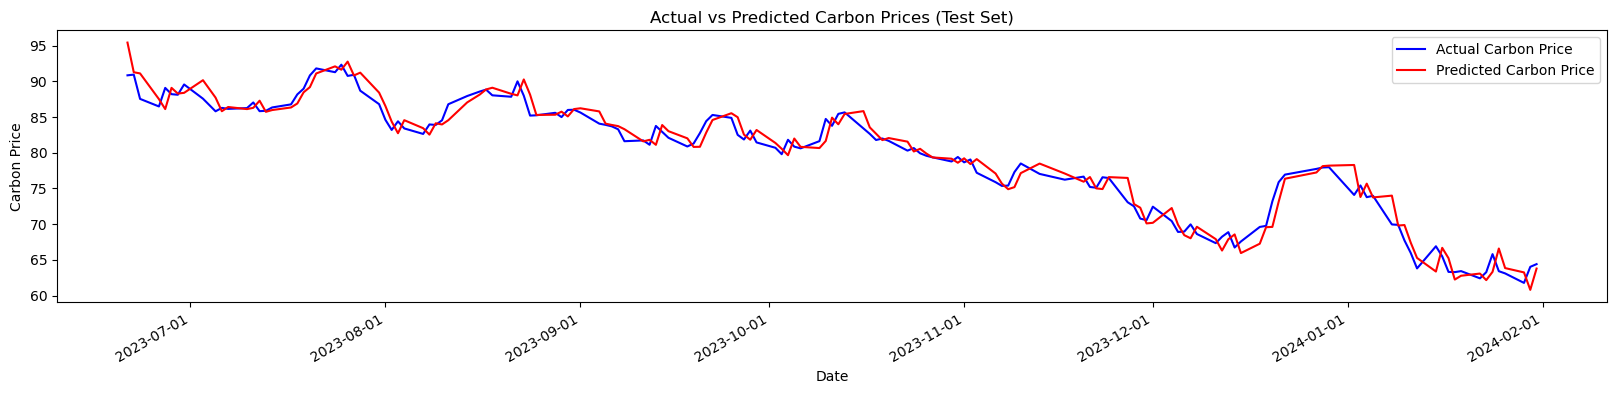

In [86]:
y_test_pred = np.array(y_test_pred)
date_test = df['Date'][test_indices_diff]

plt.figure(figsize=(20,4))
plt.plot(date_test, y_test, label='Actual Carbon Price', color='blue')
plt.plot(date_test, y_test_pred, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Carbon Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

In [87]:
# Evaluation on Test Set
r_squared_test = r2_score(y_test, y_test_pred)
print("Out-of-Sample R-squared:", r_squared_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Out-of-Sample RMSE: {rmse_test}")

mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Out-of-Sample MSE: {mse_test}")

mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Out-of-Sample MAE: {mae_test}")

mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f"Out-of-Sample MAPE: {mape_test}%")

Out-of-Sample R-squared: 0.9619175647715936
Out-of-Sample RMSE: 1.5586114024696909
Out-of-Sample MSE: 2.429269503908537
Out-of-Sample MAE: 1.2236585980503132
Out-of-Sample MAPE: 1.576962304569636%


## LSTM Model

In [88]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# Normalize features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features = df.drop(['Date', 'Carbon'], axis=1)
target = df['Carbon']

In [89]:
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [90]:
train_size = int(len(features_scaled) * 0.8)
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = target_scaled[:train_size], target_scaled[train_size:]

In [91]:
# Function to create sequences of past data
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])  # Sequence of time steps for features
        ys.append(y[i + time_steps])  # Target value after the sequence
    return np.array(Xs), np.array(ys)

In [92]:
# Define the look-back period
time_steps = 1

# Create sequences for training and testing
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

#### Find Best Parameters

In [93]:
# Define a function to create the LSTM model
def create_model(optimizer='rmsprop', learning_rate=0.0005):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [94]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=1)

In [95]:
param_grid = {
    'batch_size': [1, 2, 3, 4, 5],
    'epochs': [10, 50, 100],
    'optimizer': ['sgd', 'rmsprop', 'adam', 'nadam'],
    'learning_rate': [0.001, 0.0005, 0.0001]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', random_state=seed_value)
random_search_result = random_search.fit(X_train_seq, y_train_seq)

best_params = random_search_result.best_params_
print("Best Score: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Epoch 1/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0353
Epoch 2/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 3/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0092
Epoch 4/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0083
Epoch 5/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0073
Epoch 6/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0068
Epoch 7/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0064
Epoch 8/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0060
Epoch 9/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0059
Epoch 10/50
609/609 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 11/50
609/609 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 12/50
609/609 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 13/50
609/609 [====

#### In Sample Performance

In [96]:
best_model = create_model(optimizer=best_params['optimizer'], learning_rate=best_params['learning_rate'])
best_model.fit(X_train_seq, y_train_seq, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

Epoch 1/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0338
Epoch 2/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 3/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0093
Epoch 4/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0083
Epoch 5/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0072
Epoch 6/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0067
Epoch 7/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 8/50
609/609 [==============================] - 2s 4ms/step - loss: 0.0058
Epoch 9/50
609/609 [==============================] - 2s 4ms/step - loss: 0.0057
Epoch 10/50
609/609 [==============================] - 2s 4ms/step - loss: 0.0052
Epoch 11/50
609/609 [==============================] - 2s 4ms/step - loss: 0.0054
Epoch 12/50
609/609 [==============================] - 2s 4ms/step - loss: 0.0051
Epoch 13/50
609/609 [====

In [97]:
y_train_pred_lstm = best_model.predict(X_train_seq)

# Inverse transform predictions and actual values to original scale
y_train_pred_lstm = scaler_target.inverse_transform(y_train_pred_lstm)
y_train_original = scaler_target.inverse_transform(y_train_seq)

# Calculate R-squared for the in-sample training data
r_squared_train = r2_score(y_train_original, y_train_pred_lstm)
print("In-Sample R-squared value:", r_squared_train)

In-Sample R-squared value: 0.9564964933611515


In [98]:
# Calculate RMSE, MSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_lstm))
mse = mean_squared_error(y_train_original, y_train_pred_lstm)
mae = mean_absolute_error(y_train_original, y_train_pred_lstm)
mape = np.mean(np.abs((y_train_original - y_train_pred_lstm) / y_train_original)) * 100
print(f"In-Sample RMSE: {rmse}")
print(f"In-Sample MSE: {mse}")
print(f"In-Sample MAE: {mae}")
print(f"In-Sample MAPE: {mape}%")

In-Sample RMSE: 3.6545807533877293
In-Sample MSE: 13.355960483032023
In-Sample MAE: 2.7945312419822455
In-Sample MAPE: 3.9178542693357215%


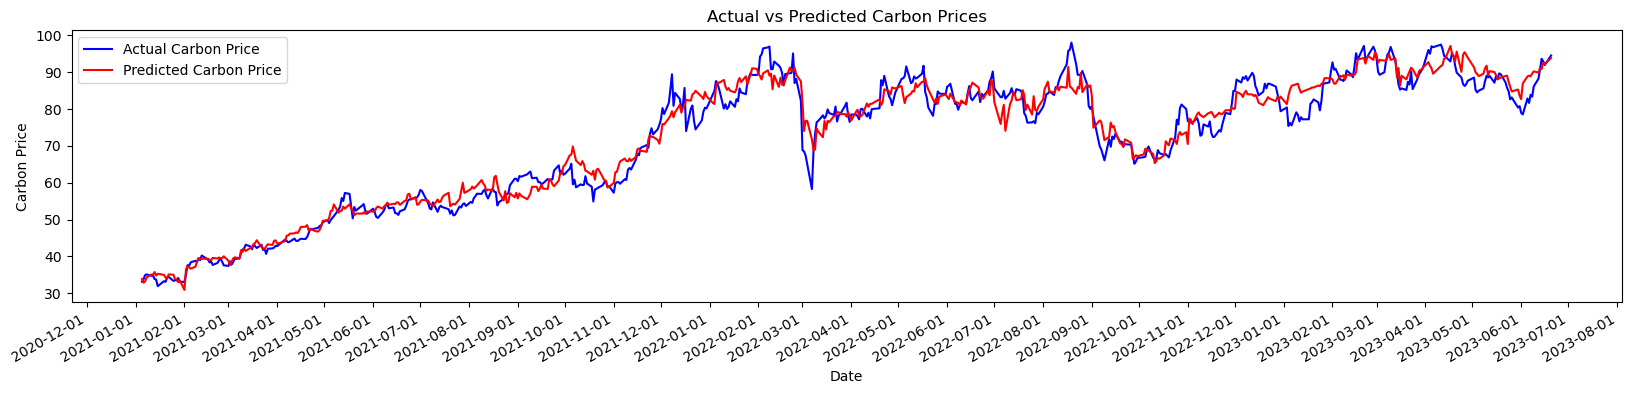

In [99]:
dates = df['Date']
date_train = dates[train_indices]

plt.figure(figsize=(20,4))
plt.plot(date_train[time_steps:], y_train_original, label='Actual Carbon Price', color='blue')
plt.plot(date_train[time_steps:], y_train_pred_lstm, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format for date rotation and readability
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()

#### Out of Sample Performance

In [100]:
history_X_lstm = X_train_seq.tolist()
history_y_lstm = y_train_seq.tolist()
y_test_pred_lstm = []

best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_optimizer = 'rmsprop'

# Define the LSTM model using the best parameters
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=best_optimizer)

# Train the model on the initial training set
X_initial = np.array(history_X_lstm).reshape(len(history_X_lstm), X_train_seq.shape[1], X_train_seq.shape[2])
y_initial = np.array(history_y_lstm)
model.fit(X_initial, y_initial, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Rolling walk-forward prediction for the test set
for t in range(len(X_test_seq)):
    # Get the exogenous input for day t from the test set
    X_input = X_test_seq[t].reshape(1, X_train_seq.shape[1], X_train_seq.shape[2])  # Reshape input for LSTM

    # Predict the next value (e.g., carbon price for day t)
    forecast = model.predict(X_input, batch_size=best_batch_size)
    y_test_pred_lstm.append(forecast[0][0])  # Store the prediction

    # Update history with the actual test data for the next iteration
    history_y_lstm.append(y_test_seq[t])  # Append the actual value for day t
    history_X_lstm.append(X_test_seq[t])  # Append the exogenous variables for day t

    # Update the model with the new data point (continual training)
    X_train_rolling = np.array(history_X_lstm[-best_batch_size:]).reshape(best_batch_size, X_train_seq.shape[1], X_train_seq.shape[2])
    y_train_rolling = np.array(history_y_lstm[-best_batch_size:])
    model.fit(X_train_rolling, y_train_rolling, epochs=1, batch_size=best_batch_size, verbose=0)

Epoch 1/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0325
Epoch 2/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0157
Epoch 3/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0126
Epoch 4/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0118
Epoch 5/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0102
Epoch 6/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 7/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 8/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 9/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0080
Epoch 10/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 11/50
609/609 [==============================] - 2s 3ms/step - loss: 0.0076
Epoch 12/50
609/609 [==============================] - 1s 2ms/step - loss: 0.0072
Epoch 13/50
609/609 [====

In [101]:
# Inverse transform predictions and actual values to original scale
y_test_pred_lstm = scaler_target.inverse_transform(np.array(y_test_pred_lstm).reshape(-1, 1))
y_test_actual = scaler_target.inverse_transform(np.array(y_test_seq).reshape(-1, 1))

In [102]:
# Calculate R-squared for out-of-sample test data
r_squared_test = r2_score(y_test_actual, y_test_pred_lstm)
print("Out-of-Sample R-squared value:", r_squared_test)

Out-of-Sample R-squared value: 0.9443385968769711


In [103]:
# Calculate RMSE for out-of-sample test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_lstm))
print(f"Out-of-Sample RMSE: {rmse_test}")

# Calculate MSE for out-of-sample test data
mse_test = mean_squared_error(y_test_actual, y_test_pred_lstm)
print(f"Out-of-Sample MSE: {mse_test}")

# Calculate MAE for out-of-sample test data
mae_test = mean_absolute_error(y_test_actual, y_test_pred_lstm)
print(f"Out-of-Sample MAE: {mae_test}")

# Calculate MAPE for out-of-sample test data
mape_test = np.mean(np.abs((y_test_actual - y_test_pred_lstm) / y_test_actual)) * 100
print(f"Out-of-Sample MAPE: {mape_test}%")

Out-of-Sample RMSE: 1.877879417860659
Out-of-Sample MSE: 3.526431108024688
Out-of-Sample MAE: 1.400457333012631
Out-of-Sample MAPE: 1.7816306275369744%


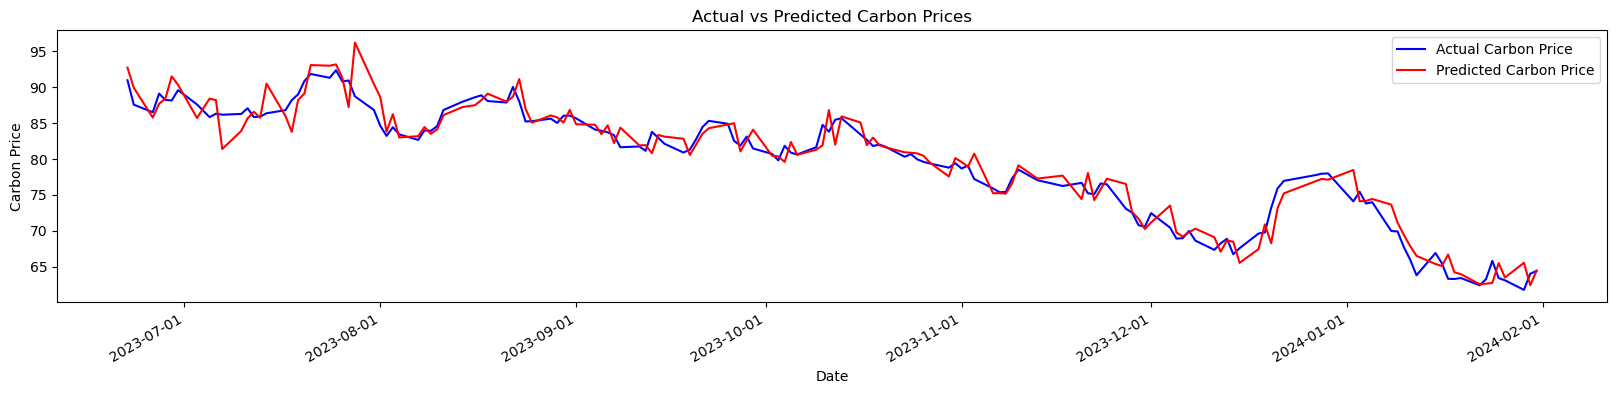

In [104]:
date_test = dates[train_size + time_steps:train_size + time_steps + len(y_test_actual)]

y_test_actual_flat = y_test_actual.flatten()
y_test_pred_lstm_flat = y_test_pred_lstm.flatten()

plt.figure(figsize=(20,4))
plt.plot(date_test, y_test_actual_flat, label='Actual Carbon Price', color='blue')
plt.plot(date_test, y_test_pred_lstm_flat, label='Predicted Carbon Price', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Auto-format for date rotation and readability
plt.title('Actual vs Predicted Carbon Prices')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.show()